In [1]:
import sys
# append the path of the parent directory
sys.path.append("..")

# External library imports
import torch
import torch.nn as nn
import numpy as np
import random
from torch.optim import Adam
from torch.utils.data import DataLoader, Subset, random_split

# internal library imports
from dataset import DebrisStatePairsDataset
from model import UNet, ComplexCNN, LargeUNet, SimpleUNet
from train import TrainerPairs, CustomDebrisLoss
from util.setting_utils import set_seed




In [2]:
# Set the random seed for multiple libraries to ensure repeatability

set_seed(42)

In [3]:
# Parameters

root_dir = r'/home/tom/repos/dyna-landslide-surrogate/data_small'
checkpoint_dir = r'/home/tom/repos/dyna-landslide-surrogate/checkpoints'
batch_size = 32
split_proportions = (0.7, 0.15, 0.15)
epochs = 3

in_channels = 3  # Number of input channels (e.g., terrain, velocity, thickness)
out_channels = 2  # Number of output channels (e.g., next velocity, next thickness)

In [4]:
# Data set up

# Initialize dataset with scaling
dataset = DebrisStatePairsDataset(root_dir, array_size=256, apply_scaling=True)

# Split dataset into train, validation, and test sets and create dataloaders
train_loader, val_loader, test_loader = dataset.create_dataloaders(split_proportions, batch_size, random_state=42)



# Dataset stats
print(f"Total dataset size: {len(dataset)}")
print(f"Train size: {len(train_loader.dataset)}, Validation size: {len(val_loader.dataset)}, Test size: {len(test_loader.dataset)}")

Total dataset size: 2593
Train size: 1830, Validation size: 340, Test size: 423


In [5]:
def compute_min_max(dataset):
    min_elevation = np.inf
    max_elevation = -np.inf
    min_velocity = np.inf
    max_velocity = -np.inf
    min_thickness = np.inf
    max_thickness = -np.inf

    for cnn_input, _ in dataset:
        elevation = cnn_input[0, :, :].numpy()
        thickness = cnn_input[1, :, :].numpy()
        velocity = cnn_input[2, :, :].numpy()

        min_elevation = min(min_elevation, elevation.min())
        max_elevation = max(max_elevation, elevation.max())
        min_velocity = min(min_velocity, velocity.min())
        max_velocity = max(max_velocity, velocity.max())
        min_thickness = min(min_thickness, thickness.min())
        max_thickness = max(max_thickness, thickness.max())

    return min_elevation, max_elevation, min_velocity, max_velocity, min_thickness, max_thickness

In [6]:
# Check the range of values in each dataset
train_min_max = compute_min_max(train_loader.dataset)
val_min_max = compute_min_max(val_loader.dataset)
test_min_max = compute_min_max(test_loader.dataset)

print("Train dataset range:")
print("Elevation: [{:.2f}, {:.2f}]".format(*train_min_max[:2]))
print("Velocity: [{:.2f}, {:.2f}]".format(*train_min_max[2:4]))
print("Thickness: [{:.2f}, {:.2f}]".format(*train_min_max[4:]))

print("\nValidation dataset range:")
print("Elevation: [{:.2f}, {:.2f}]".format(*val_min_max[:2]))
print("Velocity: [{:.2f}, {:.2f}]".format(*val_min_max[2:4]))
print("Thickness: [{:.2f}, {:.2f}]".format(*val_min_max[4:]))

print("\nTest dataset range:")
print("Elevation: [{:.2f}, {:.2f}]".format(*test_min_max[:2]))
print("Velocity: [{:.2f}, {:.2f}]".format(*test_min_max[2:4]))
print("Thickness: [{:.2f}, {:.2f}]".format(*test_min_max[4:]))

Train dataset range:
Elevation: [0.00, 10.00]
Velocity: [0.00, 10.00]
Thickness: [0.00, 10.00]

Validation dataset range:
Elevation: [0.00, 4.63]
Velocity: [0.00, 10.35]
Thickness: [0.00, 10.00]

Test dataset range:
Elevation: [0.00, 7.59]
Velocity: [0.00, 8.32]
Thickness: [0.00, 10.00]


In [7]:
# Model setup

# models = [
#     # {'model': ComplexCNN(), 'name': 'complex_cnn'}, 
#     # {'model': LargeUNet(), 'name': 'large_unet'},
#     {'model': UNet(in_channels=in_channels, out_channels=out_channels), 'name': 'unet_fulldata_pair_customloss0-66'}
# ]

models = [
    {'model': ComplexCNN(), 'name': 'complex_cnn'} 
    # {'model': LargeUNet(), 'name': 'large_unet'},
    # {'model': UNet(in_channels=in_channels, out_channels=out_channels), 'name': 'unet_fulldata_pair_customloss0-66'}
]

Training on device: cuda.
Using 2 GPUs!
Training complex_cnn...
Epoch [1/3], Loss: 0.0335
Validation Loss: 0.0127
Epoch [2/3], Loss: 0.0128
Validation Loss: 0.0093
Epoch [3/3], Loss: 0.0103
Validation Loss: 0.0061
Model saved to /home/tom/repos/dyna-landslide-surrogate/checkpoints/complex_cnn/model_epoch_3.pth
Losses saved to /home/tom/repos/dyna-landslide-surrogate/checkpoints/complex_cnn/losses_epoch_3.json
Loss plot saved to /home/tom/repos/dyna-landslide-surrogate/checkpoints/complex_cnn/loss_plot.png


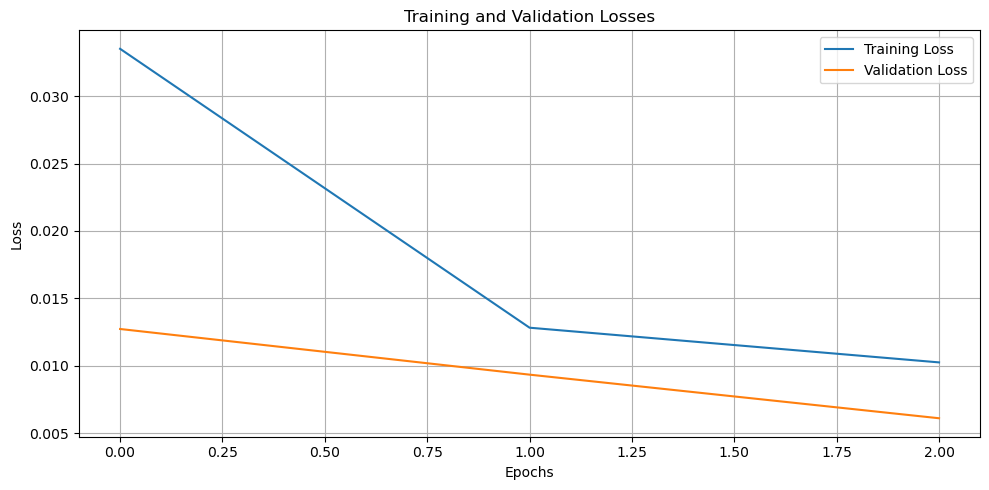

Finished training complex_cnn.


In [8]:
# Set up CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Training on device: {device}.")

# Train each model
for model_info in models:
    
    model = model_info['model']

    # Check if multiple GPUs are available and wrap the model using nn.DataParallel
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs!")
        # This will wrap the model for use with multiple GPUs
        model = torch.nn.DataParallel(model)
    
    # Move model to the appropriate device
    model.to(device)
    
    # Define the loss function and optimizer
    # criterion = nn.MSELoss()
    criterion = nn.L1Loss()
    # criterion = CustomDebrisLoss(loss_fn_zero=nn.SmoothL1Loss(), loss_fn_debris=nn.SmoothL1Loss(), debris_weight=0.66)
    optimizer = Adam(model.parameters(), lr=1e-3)
    
    # Initialize the trainer
    model_name = model_info['name']
    trainer = TrainerPairs(model, optimizer, criterion, device, model_name=model_name, checkpoint_dir=checkpoint_dir)
    
    # Train the model
    print(f"Training {model_name}...")
    trainer.train(train_loader, val_loader, epochs=epochs, checkpoint_interval=5)
    
    print(f"Finished training {model_name}.")

Plotting losses...


Loss plot saved to /home/tom/repos/dyna-landslide-surrogate/checkpoints/complex_cnn/loss_plot.png


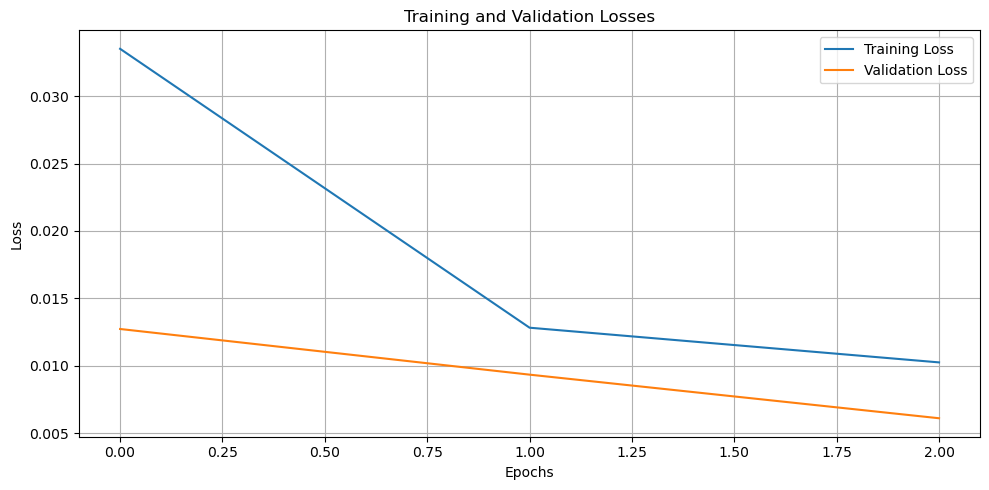

In [9]:
# Evaluate the model on the test set
print("Plotting losses...")
trainer.plot_losses()

In [10]:
# Evaluate the model on the test set
print("Evaluating the model on the test set...")
trainer.test(test_loader)


Evaluating the model on the test set...
Test Loss: 0.0059


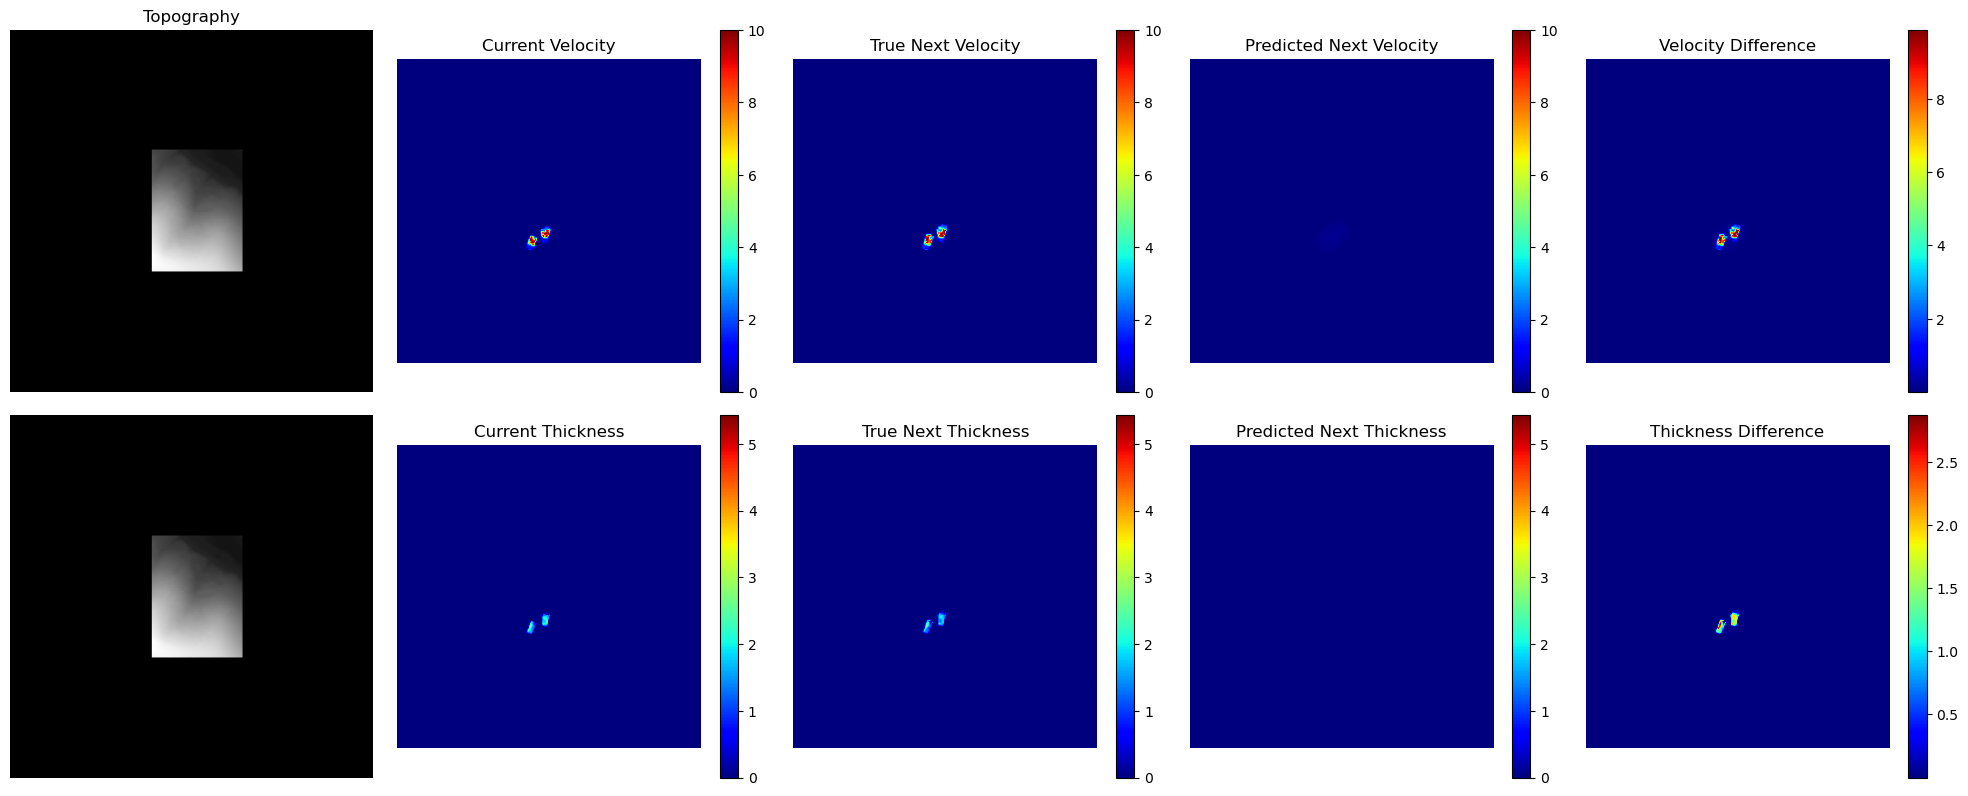

In [12]:
trainer.plot_predictions(test_loader, num_predictions=1)

(0.0, 280.02, 0.0, 30.0, 0.0, 8.0)

In [14]:
model_number = '00015'
state_number = 2
num_timesteps = 3


input_tensor = trainer.create_inference_input(root_dir=root_dir, 
                                              model_number=model_number, 
                                              state_number=state_number, 
                                              array_size=256)

In [15]:
inferred = trainer.infer(input_tensor, num_timesteps=num_timesteps)

In [16]:
for key, value in inferred.items():
    print(f"Key: {key} -> Type of value: {type(value).__name__}")

Key: 1 -> Type of value: ndarray
Key: 2 -> Type of value: ndarray
Key: 3 -> Type of value: ndarray
